# Understanding Gradient Boosting Models
To follow along directly:
1. Clone or download repo at https://github.com/numeristical/resources
2. Navigate to Folder `Understand_GB_Models`
3. Find this notebook `ICE_plot_MLI_ICU.ipynb`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import xgboost as xgb
import ml_insights as mli

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

# ICE-Plots for Classification Models

Generally speaking, ICE-plots work the same way in classification models as they do in regression models.  However, there are some key differences.

## Binary Classification
- For a binary classification model, we usually plot the probability of y=1 ("in-class") as a function of the target value.
- However, in many cases it may make more sense to plot the "log-odds" or "logit" of the probability.
- Plotting the log-odds is particularly appropriate in imbalanced problems where the difference between (say) a probability of .01 and .0001 is very important.  This difference will look small on probability scale plots, but significant on logit scale plots
- It is worth noting that all major gradient boosting packages (as far as I am aware) operate on the log-odds scale internally.  That is, the loss function (and its gradient) are computed with respect to the log-odds of the probability, and the output of the tree is a number on the log-odds scale.  Only after all the log-odds values are summed is the result converted back to probability scale.
- For those reasons I generally prefer looking at these on the 'logit' scale (using `y_scaling='logit'`)

## Multi-Classification
- When you have multiple classes, you can inspect the probabilities (log-odds) of each class individually by using the `class_num` parameter.  For example, if you have 10 classes, and want to see how the probability of class 7 changes with the feature values, you would set `class_num=7`.  We will not explore multi-classification in this notebook.

## MIMIC ICU data set

We illustrate calibration using a mortality model on the MIMIC ICU data. Each row represents a hospital stay of an individual patient. We have many lab values and vital sign measurements, as well as an indicator of whether or not the patient died in the hospital.

*MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). https://mimic.physionet.org

In [2]:
df_icu = pd.read_csv('../GBIP/data/lab_vital_icu_table.csv')

In [3]:
df_icu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59726 entries, 0 to 59725
Data columns (total 79 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_id            59726 non-null  int64  
 1   hadm_id               59726 non-null  int64  
 2   icustay_id            59726 non-null  int64  
 3   aniongap_min          52706 non-null  float64
 4   aniongap_max          52706 non-null  float64
 5   albumin_min           19066 non-null  float64
 6   albumin_max           19066 non-null  float64
 7   bicarbonate_min       53429 non-null  float64
 8   bicarbonate_max       53429 non-null  float64
 9   bilirubin_min         25405 non-null  float64
 10  bilirubin_max         25405 non-null  float64
 11  creatinine_min        52185 non-null  float64
 12  creatinine_max        52185 non-null  float64
 13  chloride_min          53668 non-null  float64
 14  chloride_max          53668 non-null  float64
 15  hematocrit_min     

In [4]:
df_icu.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'aniongap_min', 'aniongap_max',
       'albumin_min', 'albumin_max', 'bicarbonate_min', 'bicarbonate_max',
       'bilirubin_min', 'bilirubin_max', 'creatinine_min', 'creatinine_max',
       'chloride_min', 'chloride_max', 'hematocrit_min', 'hematocrit_max',
       'hemoglobin_min', 'hemoglobin_max', 'lactate_min', 'lactate_max',
       'platelet_min', 'platelet_max', 'potassium_min', 'potassium_max',
       'ptt_min', 'ptt_max', 'inr_min', 'inr_max', 'pt_min', 'pt_max',
       'sodium_min', 'sodium_max', 'bun_min', 'bun_max', 'wbc_min', 'wbc_max',
       'subject_id.1', 'hadm_id.1', 'icustay_id.1', 'gender', 'admittime',
       'dischtime', 'los_hospital', 'age', 'ethnicity', 'admission_type',
       'hospital_expire_flag', 'hospstay_seq', 'first_hosp_stay', 'intime',
       'outtime', 'los_icu', 'icustay_seq', 'first_icu_stay', 'subject_id.2',
       'hadm_id.2', 'icustay_id.2', 'heartrate_min', 'heartrate_max',
       'heartrate_mean', '

In [5]:
# We select just a few of these features...
feat = [
       'albumin_min', 'lactate_max',
       'platelet_min', 'sodium_max', 
        'bun_min', 'bun_max',
        'wbc_min', 'wbc_max',
     'heartrate_mean', 'resprate_mean',
        'sysbp_min','sysbp_max', 
        'tempc_min','tempc_max']

In [6]:
X = df_icu.loc[:,feat]
y = df_icu.hospital_expire_flag 

In [7]:
X_train_full, X_test_full, y_train, y_test = train_test_split(X,y,test_size = .2, random_state=42)

In [8]:
X_train_full.shape, X_test_full.shape

((47780, 14), (11946, 14))

In [9]:
# create data sets of just the smaller subset of features
X_train = X_train_full.loc[:, feat]
X_test = X_test_full.loc[:, feat]

In [10]:
# Get the mean of your target variable
np.mean(df_icu.hospital_expire_flag)

0.10874660951679335

## Fit a model

In [11]:
# Tune the max_depth with early stopping
mdmin, mdmax = (1,11)
llvec = []
for md in range(mdmin,mdmax):
    xgb1 = xgb.XGBClassifier(max_depth=md, n_estimators = 5000, 
                         learning_rate=.03, early_stopping_rounds=20)
    xgb1.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
    preds = xgb1.predict_proba(X_test)
    llvec.append(log_loss(y_test, preds))

Best max-depth=3


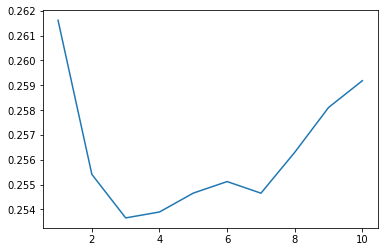

In [12]:
mdvals=np.arange(mdmin, mdmax)
best_md=mdvals[np.argmin(llvec)]
plt.plot(mdvals, llvec)
print(f'Best max-depth={best_md}')

In [13]:
xgb1 = xgb.XGBClassifier(max_depth=best_md, n_estimators = 3000, 
                     learning_rate=.03, early_stopping_rounds=20)
xgb1.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=3000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Choose some test pts for the ICE-plot

In [14]:
np.random.seed(42)
indices = np.random.choice(np.arange(X_test_full.shape[0]), size=5)
indices

array([ 7270,   860,  5390,  5191, 11284])

In [15]:
test_pts = X_test.iloc[indices,:]
test_pts

,albumin_min,lactate_max,platelet_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max,heartrate_mean,resprate_mean,sysbp_min,sysbp_max,tempc_min,tempc_max
53386,3.3,NaN,379.0,140.0,53.0,67.0,10.0,10.0,83.200000,32.369231,98.0,151.0,36.333334,37.444445
49397,NaN,3.7,324.0,144.0,14.0,19.0,9.6,12.8,65.884615,12.612903,91.0,179.0,36.666667,37.666668
36937,2.9,1.8,217.0,143.0,30.0,43.0,19.0,21.8,103.093750,24.156250,90.0,139.0,35.722222,36.944444
8480,NaN,NaN,102.0,146.0,53.0,56.0,7.8,9.9,74.250000,20.529412,95.0,137.0,34.944444,35.444444
28587,NaN,2.2,247.0,142.0,33.0,44.0,10.4,10.4,98.827586,22.500000,92.0,136.0,35.666667,36.944444


## Get the range dictionary, and make some adjustments

In [16]:
rd0 = mli.get_range_dict(X_train)
rd0['wbc_min'] = np.linspace(0,50,101)
rd0['wbc_max'] = np.linspace(0,50,101)
rd0['platelet_min'] = np.linspace(0,1000,101)
rd0['sodium_max'] = np.linspace(110,170,61)
rd0['tempc_min'] = np.linspace(30,42,111)
rd0['tempc_max'] = np.linspace(30,42,111)


## Create the ICE-Plots (on both scales)

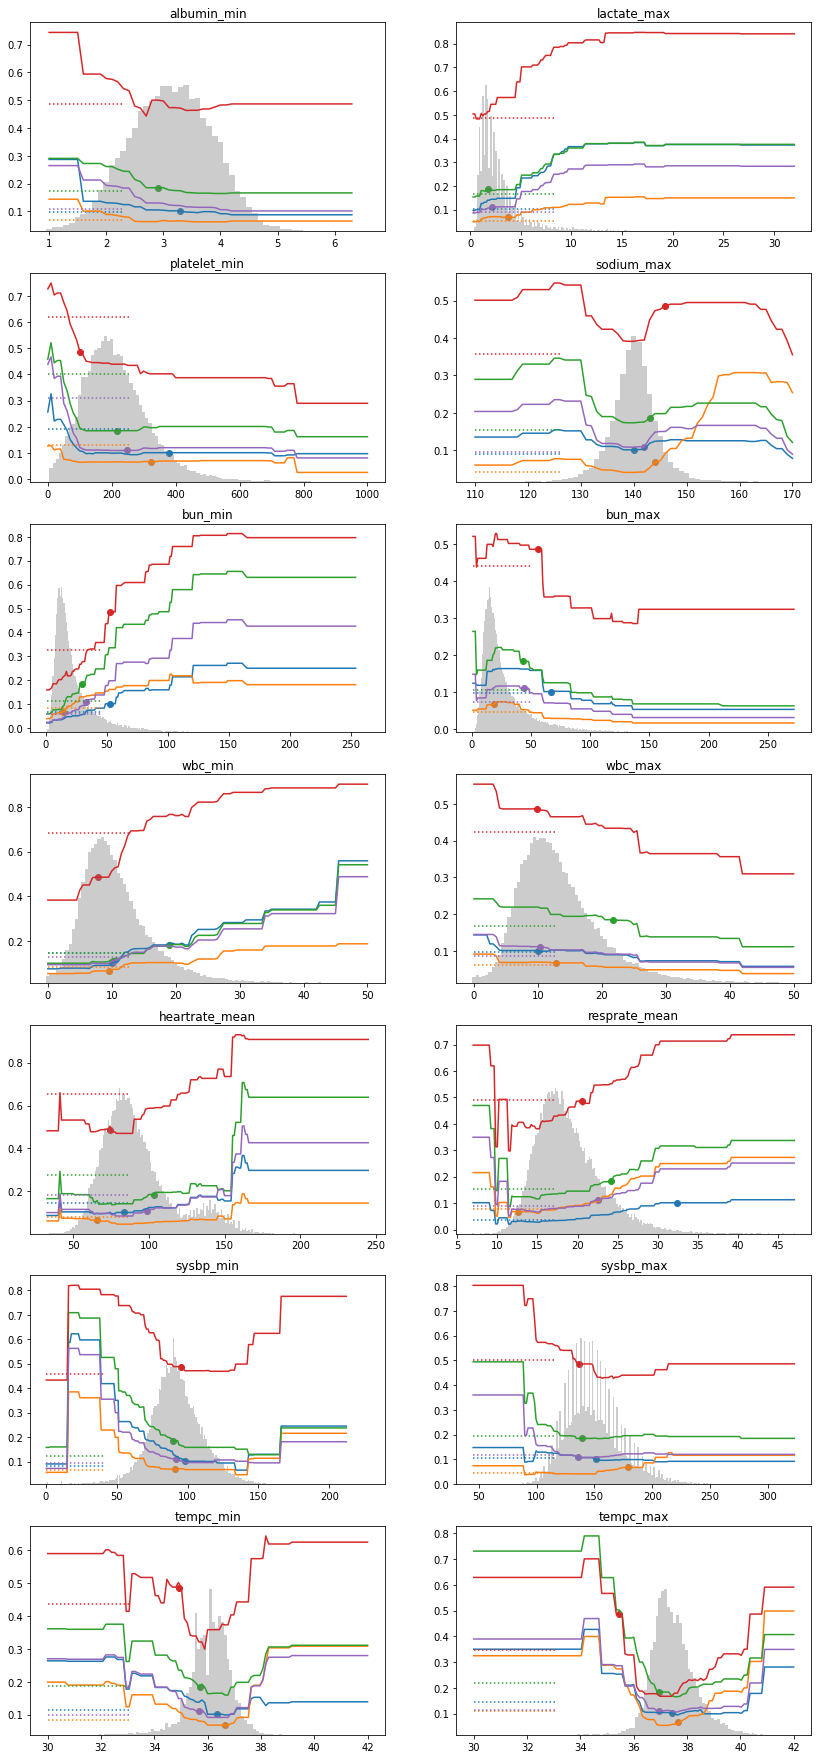

In [17]:
mli.ice_plot(xgb1, test_pts, test_pts.columns, rd0, pred_fn = 'predict_proba',
            show_nan=True, plots_per_row=2, auto_plot_height=4.5, auto_plot_width=7,
             show_hist=True, data_for_hist=X_train)


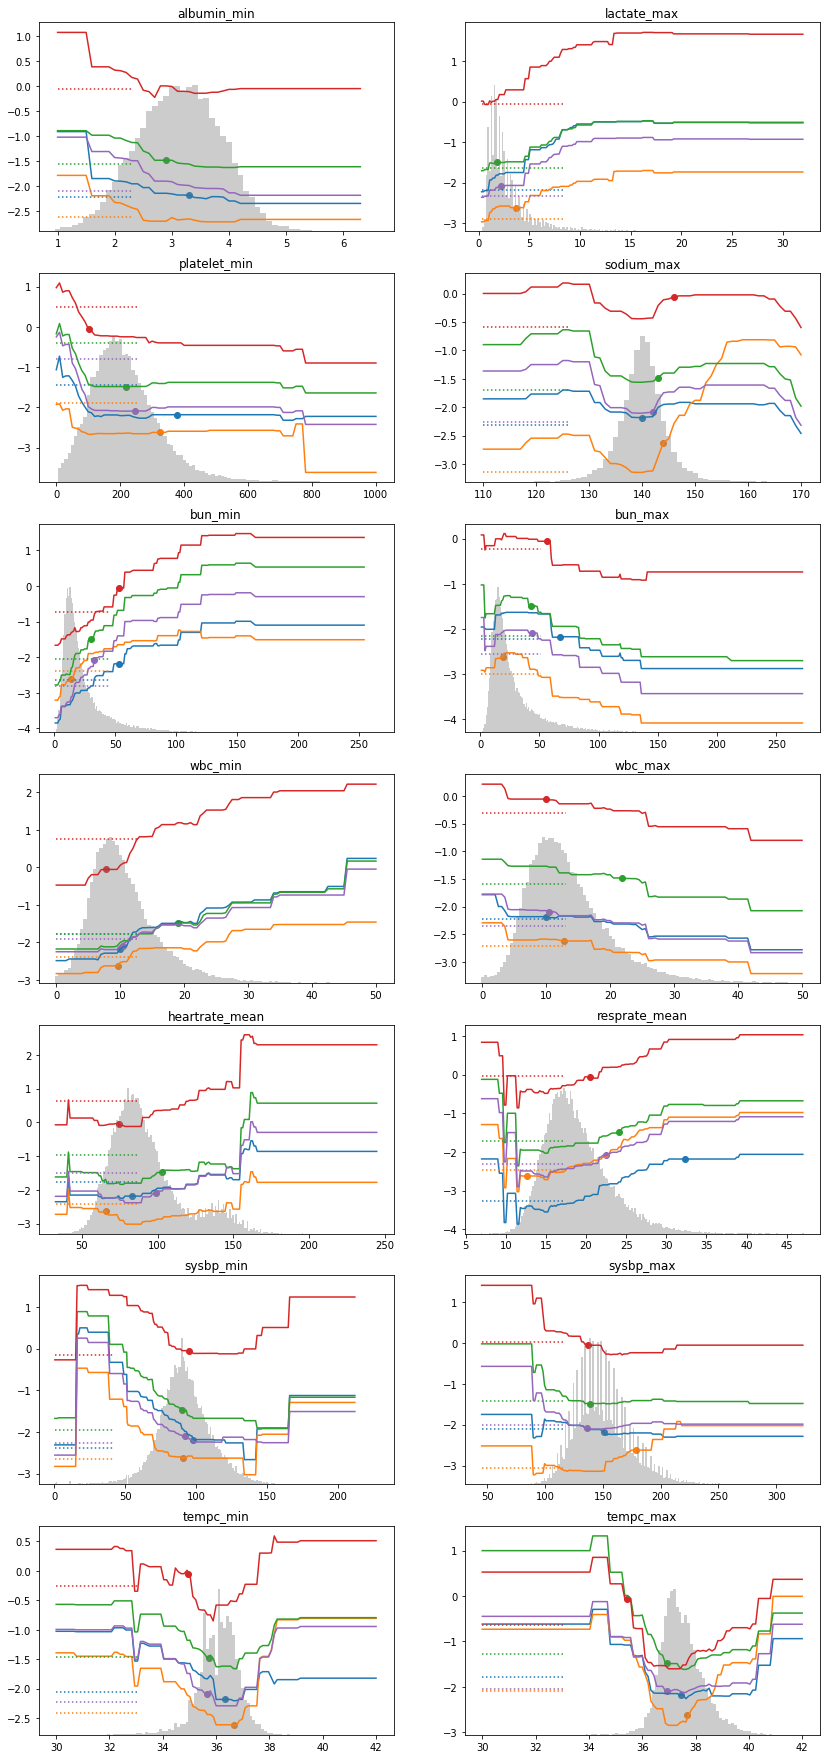

In [18]:
mli.ice_plot(xgb1, test_pts, test_pts.columns, rd0, pred_fn = 'predict_proba',
            show_nan=True, plots_per_row=2,  auto_plot_height=4.5, auto_plot_width=7,
             show_hist=True, data_for_hist=X_train,
            y_scaling='logit')


## Some things to notice
- What may look like interaction effects on the probability scale are just artifacts of the difference between logit scale and probability scale. (Log-odds scale is more natural and usually preferred)
- Non-monotonicity in sodium, sysbp
- When min and max are together, may make interpretation more challenging, but could also reveal interesting aspects of the data
- Obvious edge effects in many of the variables - should be treated with caution
- Not causal!  This is an observational data set, and these counterfactuals only tell you what the model would predict.